In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import Denoiser
from scipy.stats import zscore


from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

keys = ['采集时间', '水温', 'pH', '溶解氧', '电导率', '浊度', '高锰酸盐指数','氨氮', '总磷', '总氮']
ks = ['date', 'water temperature', 'PH' ,'dissolved oxygen', 'Conductivity','Turbidity','PermanganateIndex',
        'Ammonia nitrogen','total phosphorus','total nitrogen', 'humidity','room temperature','chlorophyll','Algae density']
# data = pd.read_csv('./data0.csv')
# data['时间'] = pd.to_datetime(arg=data['时间'], format='%Y-%m-%d %H:%M:%S')
# data = data.set_index(data.columns[0])


In [62]:
excel_path = './original_data.xls'
def dataClean(excel_path, save_path ='./data2.csv',header=2, labels=['采集时间', '水温', 'pH', '溶解氧']):
    # Read the original data and copy one.
    # 'Date' is default as the first colume.
    df = pd.read_excel(excel_path, header=2, usecols=labels).copy()
    df.set_index(labels[0], inplace=True)
    
    # Clean the wrong data type and labeled them as 'None'
    for k in labels[1:]:
        df[k].mask(df[k] == '--', None, inplace=True)
    df = df.astype('float64')
    df = df.abs()
    
    # Clean the Outliers
    for k in labels[1:]:
        vals = df[k].values.copy()
        idxs = compute_zscore(df, k, 1.2)
#         idxs = detect_outlier(df, k, 4)
        vals[idxs] = None
        df.loc[:, k] = vals
    
    # Drop rows with nan
    df.dropna(inplace=True)
    
    #  Denoise by moving average
    for k in labels[1:]:
        vals = df[k].values.copy()
        smooth_vals = pd.Series(vals).ewm(span=42).mean()
#         smooth_vals = pd.Series(vals).rolling(30).mean()
        df.loc[:, k] = smooth_vals.values
        
    # Sort by the date and remove incomplete data
    ls = []
    df = df.reset_index(drop=False)
    times = pd.to_datetime(arg=df[labels[0]], format='%Y-%m-%d %H:%M:%S')
    for group in df.groupby([times.dt.year, times.dt.month, times.dt.day]):
#         if group[1].shape[0] == 6:
        dfn = group[1][::-1].values.copy()
        ls.append(dfn)
    arr = np.concatenate(ls, axis=0)
    new_data = pd.DataFrame(arr, columns=labels)
    new_data.to_csv(save_path, index=False)
    return new_data

def compute_zscore(df, k, threshold=1.5):
    '''
    使用标准差来筛选数据，返回异常数据坐标
    '''
    all_value = df[k].values.copy()
    indices = np.array(list(map(lambda x: not x, np.isnan(all_value))))
    true_value = all_value[indices]
#     print(true_value.mean())
    z_value = zscore(true_value)
    
    all_value[indices] = z_value
    all_value = pd.Series(all_value)
    return all_value.abs() > threshold


def detect_outlier(df, label, rate=4):
    '''
    使用分位数来筛选数据，返回异常数据坐标
    '''
    all_values = df[label].values.copy()
    indices = np.array(list(map(lambda x: not x, np.isnan(all_values))))
    true_values = all_values[indices]
    
    Q1 = np.percentile(true_values, rate)
    Q3 = np.percentile(true_values, 100-rate)    
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    
    all_values = pd.Series(all_values)
    return (all_values < lower_limit)&(all_values > upper_limit)

df = dataClean(excel_path, './data3.csv', labels=['采集时间', '水温', 'pH', '溶解氧'])
df = dataClean(excel_path, './data6.csv', labels=['采集时间', '水温', 'pH', '溶解氧', '电导率', '浊度', '高锰酸盐指数'])
df = dataClean(excel_path, './data9.csv', labels=['采集时间', '水温', 'pH', '溶解氧', '电导率', '浊度', '高锰酸盐指数', '氨氮', '总磷', '总氮'])

水温
[14.96670307131505 15.099761757720664 15.227311111755817 ...
 19.753393349707164 19.77132142857143 19.779]


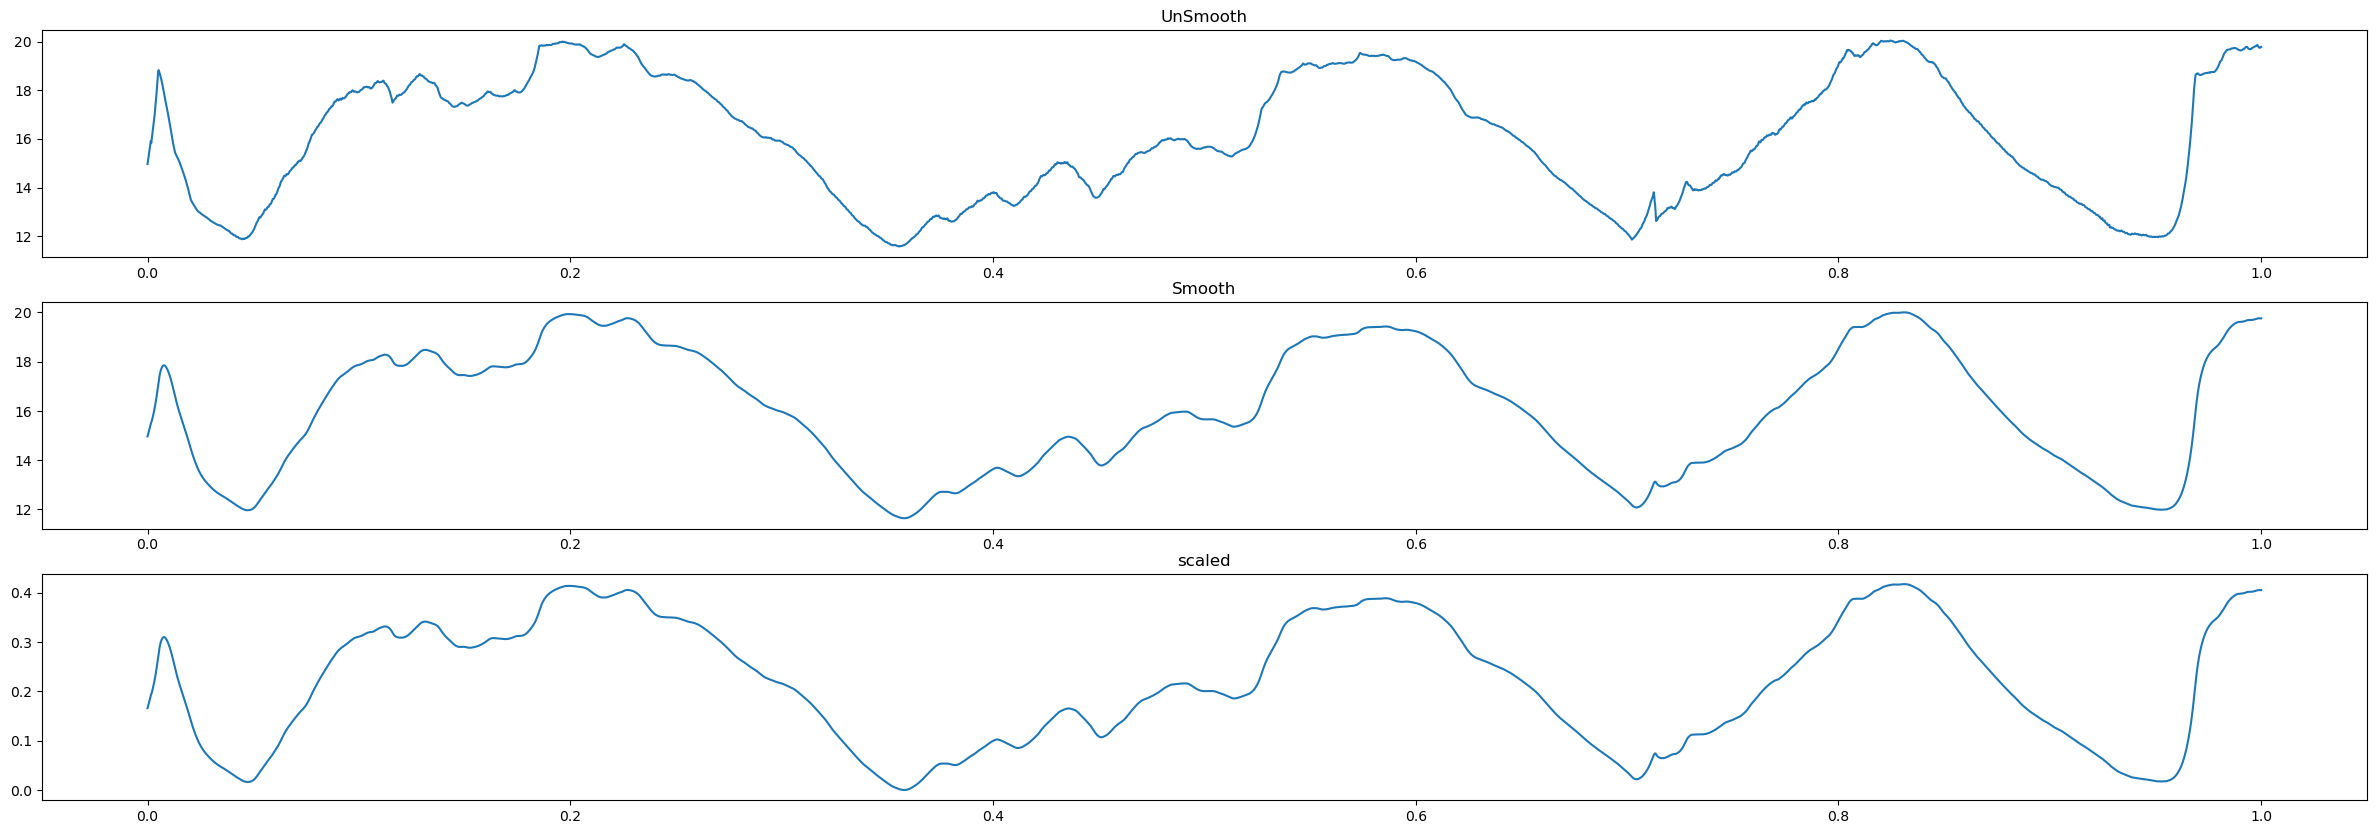

In [63]:
figure, axis = plt.subplots(3, 1, figsize=(30, 10))
name = keys[1]
print(name)
vals = df[name].values.copy()
print(vals)
X = np.linspace(0, 1, len(vals))
axis[0].plot(X, vals)
axis[0].set_title('UnSmooth')
smooth_vals = pd.Series(vals).ewm(span=30).mean()
axis[1].plot(X, smooth_vals)
axis[1].set_title('Smooth')
scaled_vals = (smooth_vals - smooth_vals.min()) / smooth_vals.max()
axis[2].plot(X, scaled_vals)
axis[2].set_title('scaled')


plt.show()

In [4]:
# features_num = len(df.keys()) 
# figure, axis = plt.subplots(features_num, 1, 
#                         figsize=(20, features_num*5))
# # X = np.linspace(0, 1, data.shape[0])
# for i in range(features_num):
#     name = df.keys()[i]
#     vals = df[name].values
#     X = np.linspace(0, 1, len(vals))
#     axis[i].plot(X, vals)
#     axis[i].set_title(f"{ks[i]}")
# plt.show()